In [2]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import random
from PIL import Image
import plotly.graph_objects as go
for dirname, _, filenames in os.walk('C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\sampleSubmission.csv
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\test1.zip
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\train.zip
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\Untitled.ipynb
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\.ipynb_checkpoints\Untitled-checkpoint.ipynb
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\test\test1\1.jpg
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\test\test1\10.jpg
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\test\test1\100.jpg
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\test\test1\1000.jpg
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\test\test1\10000.jpg
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\test\test1\10001.jpg
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\test\test1\10002.jpg
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats\test\test1\10003.jpg
C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [21]:
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')
with zipfile.ZipFile('test1.zip', 'r') as zip_ref:
    zip_ref.extractall('test')

In [3]:
train_dir = 'C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats/train/train'
test_dir = 'C:/Users/shiva_sirasanagandla/Downloads/dogs-vs-cats/test/test1'

In [4]:
def load_images(folder, img_size=(64, 64), sample_count=20, label_filter=None):
    images = []
    labels = []
    filenames = os.listdir(folder)
    
    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]
    
    random.shuffle(filenames)
    for img in filenames[:sample_count]:
        try:
            img_path = os.path.join(folder, img)
            img_pil = Image.open(img_path)
            img_pil = img_pil.resize(img_size)
            img_np = np.array(img_pil) / 255.0  # Normalize pixel values
            images.append(img_np)
            labels.append(0 if 'cat' in img else 1)
        except Exception as e:
            print(f"Error loading image {img}: {e}")
    
    return np.array(images), np.array(labels)

In [5]:
def visualize_images(images, labels, sample_count=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(sample_count):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i] == 0 else 'Dog')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

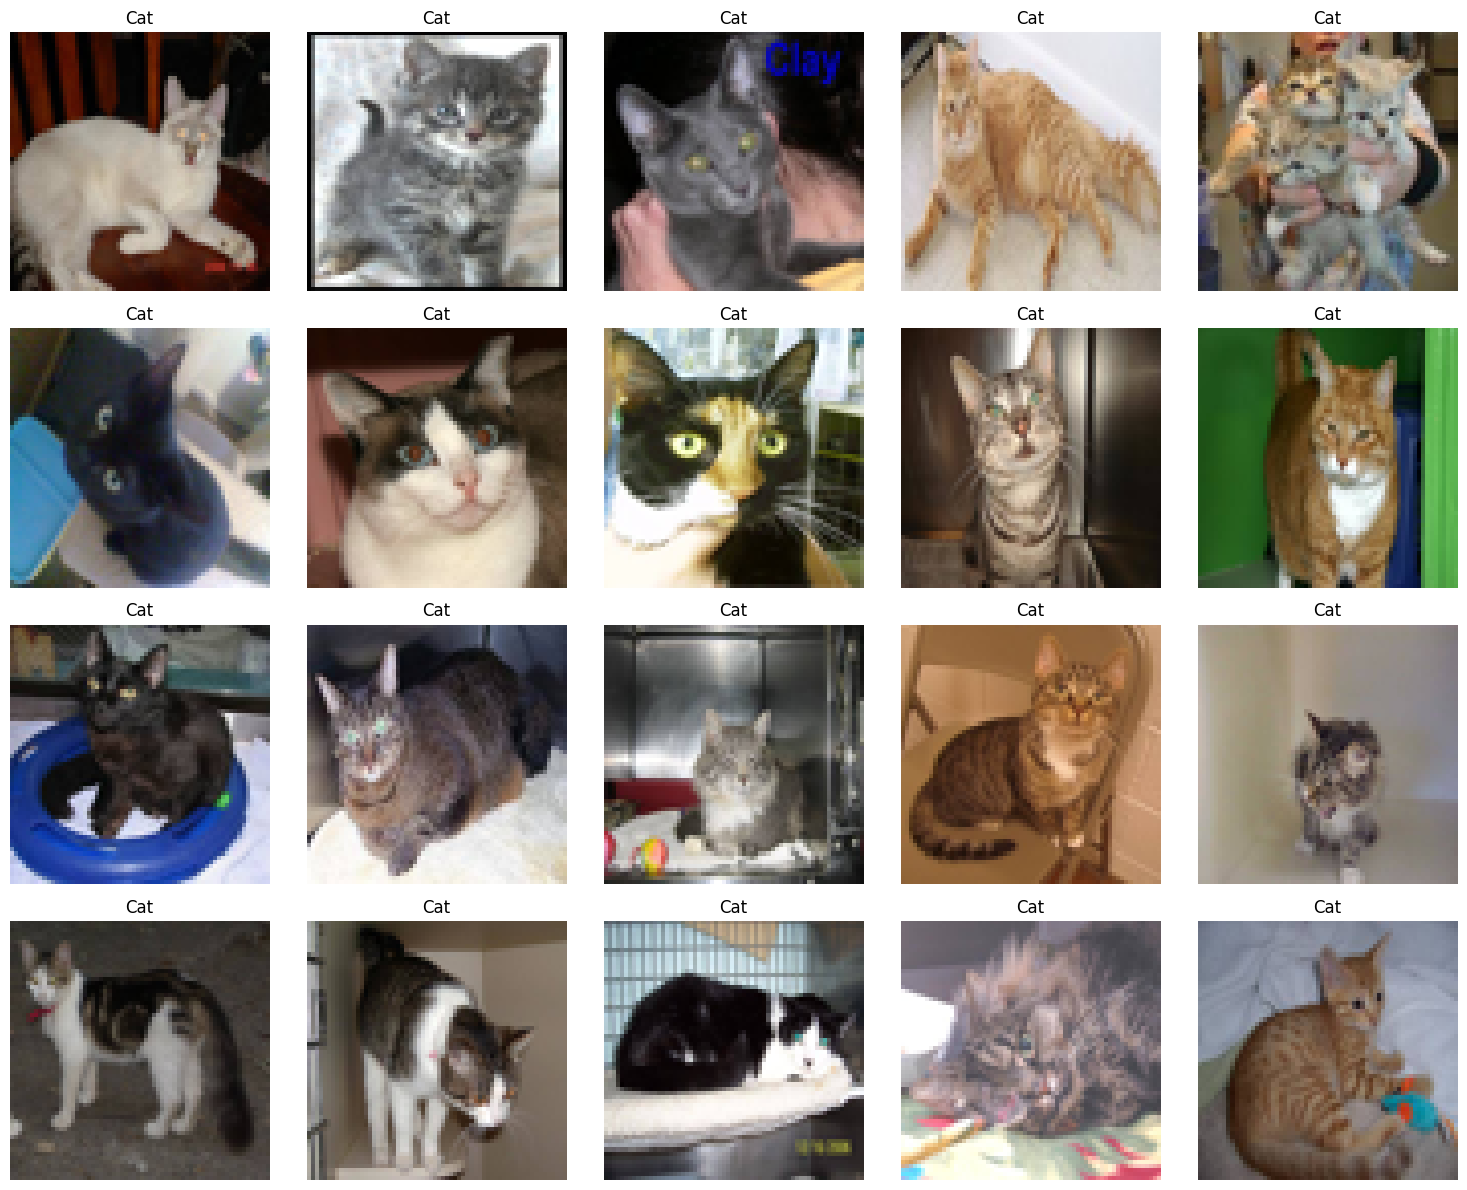

In [6]:
cat_images, cat_labels = load_images(train_dir, sample_count=20, label_filter='cat')
visualize_images(cat_images, cat_labels, sample_count=20)

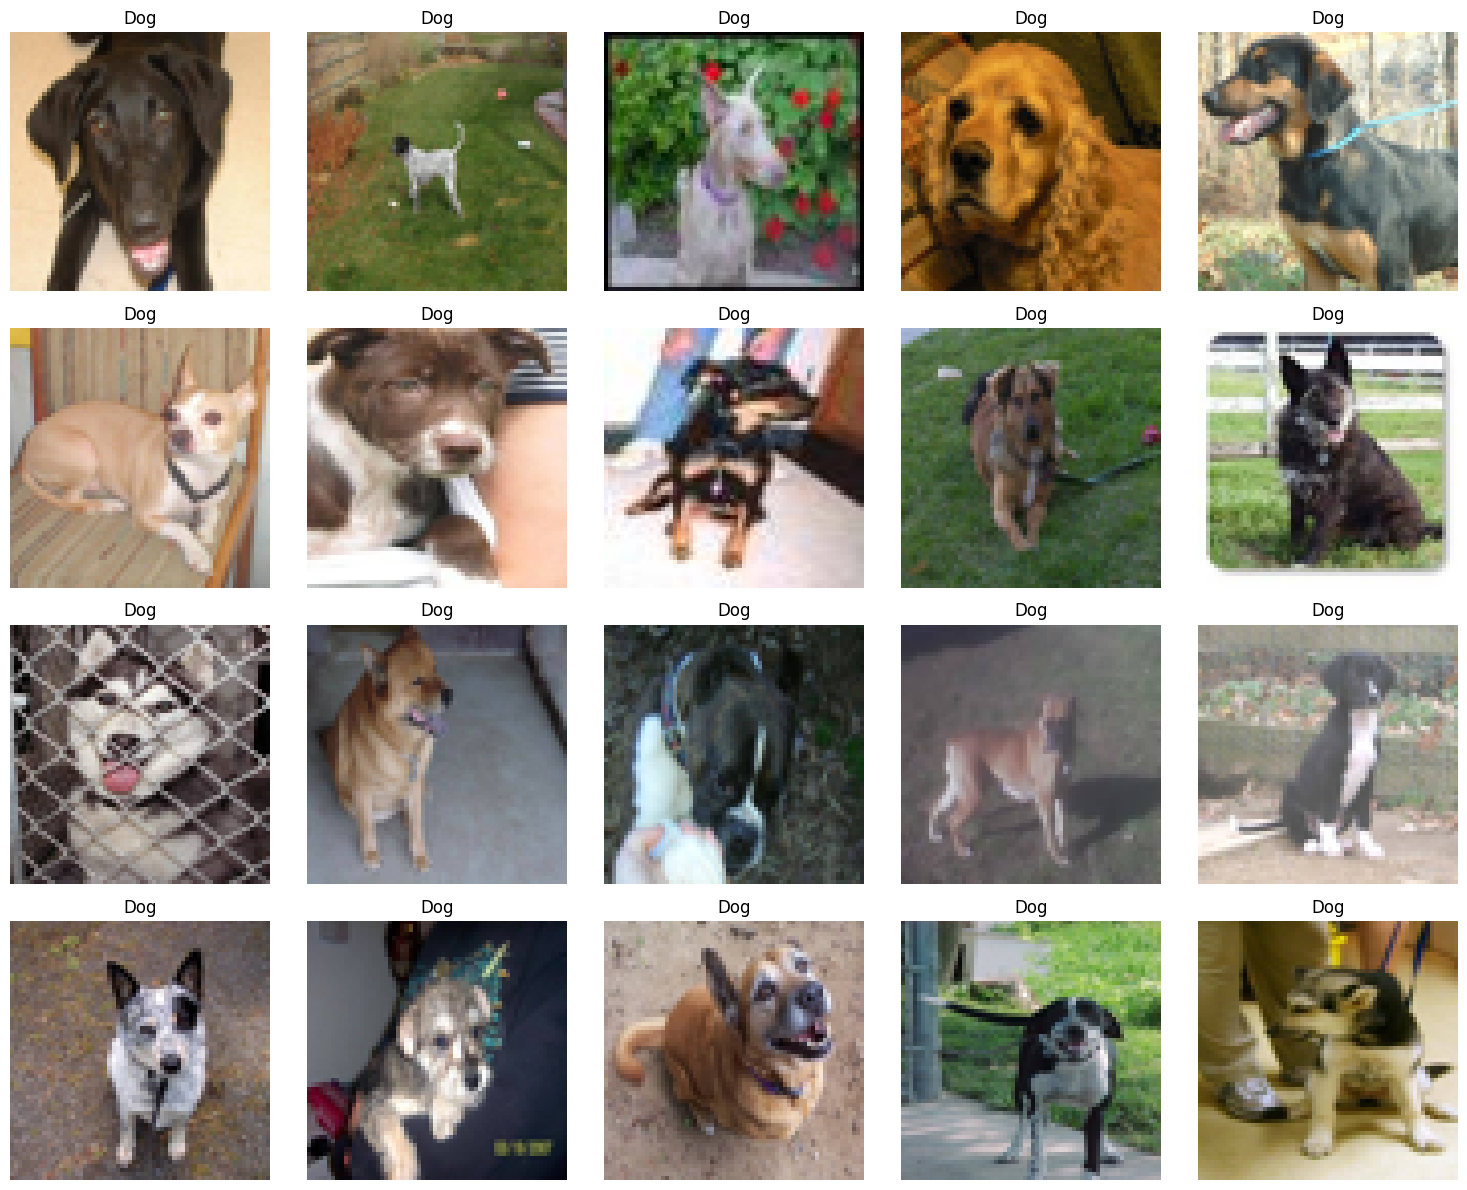

In [7]:
dog_images, dog_labels = load_images(train_dir, sample_count=20, label_filter='dog')
visualize_images(dog_images, dog_labels, sample_count=20)

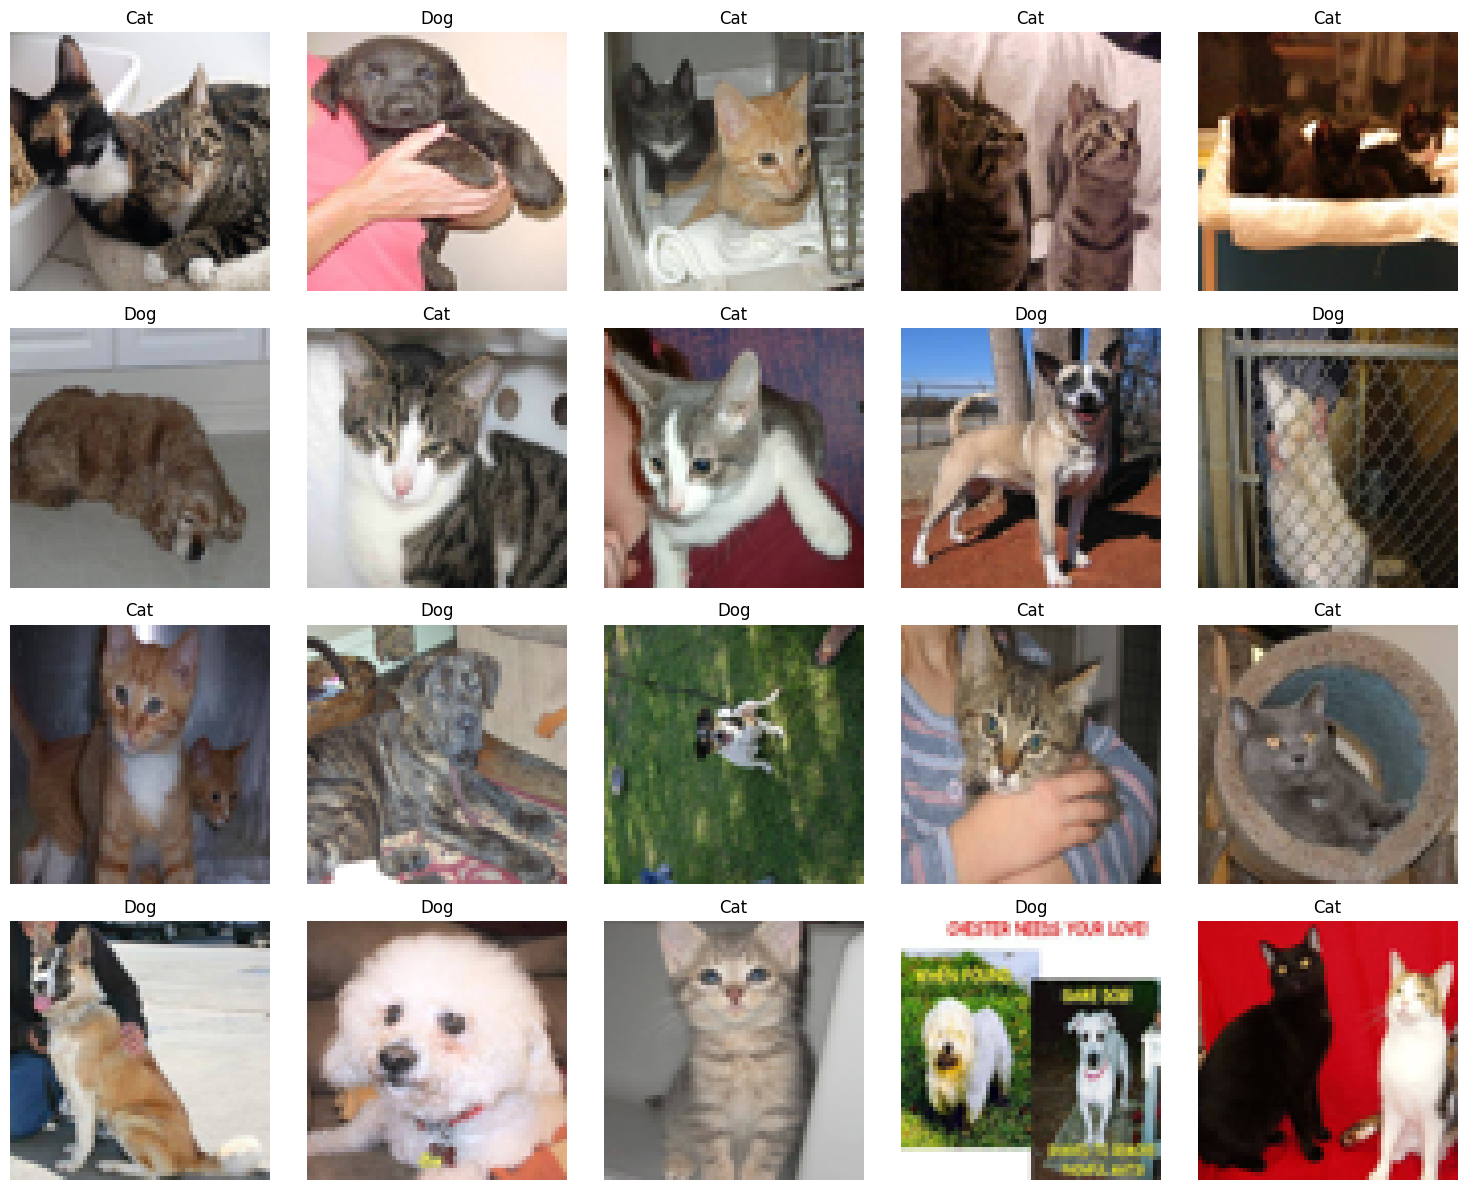

In [8]:
all_images, all_labels = load_images(train_dir, sample_count=20)
visualize_images(all_images, all_labels, sample_count=20)

In [9]:
images, labels = load_images(train_dir, sample_count=10000) 
images = images / 255.0

In [10]:
print("Shape of images array:", images.shape)

Shape of images array: (10000, 64, 64, 3)


In [11]:
print("Shape of the first image:", images[0].shape)

Shape of the first image: (64, 64, 3)


In [12]:
print(images[:2]) 
print(labels[:2])

[[[[0.00149173 0.00135333 0.00121492]
   [0.00150711 0.0013687  0.0012303 ]
   [0.00155325 0.00141484 0.00127643]
   ...
   [0.00173779 0.00159938 0.0014456 ]
   [0.00175317 0.00163014 0.00143022]
   [0.00178393 0.0016609  0.00146098]]

  [[0.00152249 0.00138408 0.00124567]
   [0.00153787 0.00139946 0.00126105]
   [0.00153787 0.00139946 0.00126105]
   ...
   [0.00178393 0.00164552 0.00152249]
   [0.00178393 0.0016609  0.00150711]
   [0.00176855 0.00164552 0.00149173]]

  [[0.00153787 0.00139946 0.00126105]
   [0.00158401 0.0014456  0.00130719]
   [0.00159938 0.00146098 0.00132257]
   ...
   [0.00181469 0.00167628 0.00153787]
   [0.00176855 0.00164552 0.00153787]
   [0.00178393 0.00164552 0.00155325]]

  ...

  [[0.00204537 0.00193772 0.00181469]
   [0.00213764 0.00202999 0.00190696]
   [0.0020915  0.00198385 0.00186082]
   ...
   [0.00222991 0.00213764 0.00201461]
   [0.00219915 0.00213764 0.00199923]
   [0.00218378 0.00210688 0.00196847]]

  [[0.00207612 0.00196847 0.00184544]
   [0.0

In [13]:
n_samples, img_height, img_width, img_channels = images.shape
images_flat = images.reshape(n_samples, -1)

In [14]:
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

In [15]:
perplexity = min(30, n_samples - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
images_tsne = tsne.fit_transform(images_flat_scaled)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(images_flat_scaled, labels, test_size=0.2, random_state=42)

In [17]:
X_train

array([[-0.12584993, -0.30733789, -0.55060857, ...,  0.40763923,
         0.47524264,  0.34881012],
       [-0.96845794, -1.34226175, -1.31113322, ..., -1.32960825,
        -1.35193993, -1.13689667],
       [-0.54001319, -0.49419914, -0.42385447, ..., -0.66709862,
        -0.62710718, -0.62204778],
       ...,
       [ 0.08837244, -0.20672029, -1.02945742, ..., -1.12349415,
        -1.14053038, -1.22515647],
       [ 0.1597799 ,  0.51197683,  0.49159186, ..., -0.75543324,
        -0.64220786, -0.81327737],
       [ 1.88784039,  1.96374502,  2.04080873, ...,  0.36347193,
         0.15812831, -0.07777896]])

In [18]:
X_val

array([[-1.09699137, -1.60099271, -1.43788732, ..., -0.91738004,
        -1.69925563, -1.445806  ],
       [ 0.1597799 ,  0.22449798,  0.3085026 , ..., -0.28431527,
        -0.20428807, -0.10719889],
       [-0.44004275, -0.24984212, -0.53652478, ..., -0.13709091,
        -0.09858329, -0.1513288 ],
       ...,
       [-1.56828059, -1.45725329, -1.48013869, ..., -0.60820887,
        -0.49120104, -0.43081819],
       [-1.31121374, -1.48600117, -1.45197111, ..., -1.16766145,
        -1.44254403, -1.35754619],
       [-1.12555435, -0.96853924, -1.07170879, ...,  0.17208025,
         0.20343035,  0.03990079]])

In [19]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
y_val

array([0, 0, 0, ..., 1, 0, 1])

In [21]:
unique, counts = np.unique(labels, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 4971, 1: 5029}


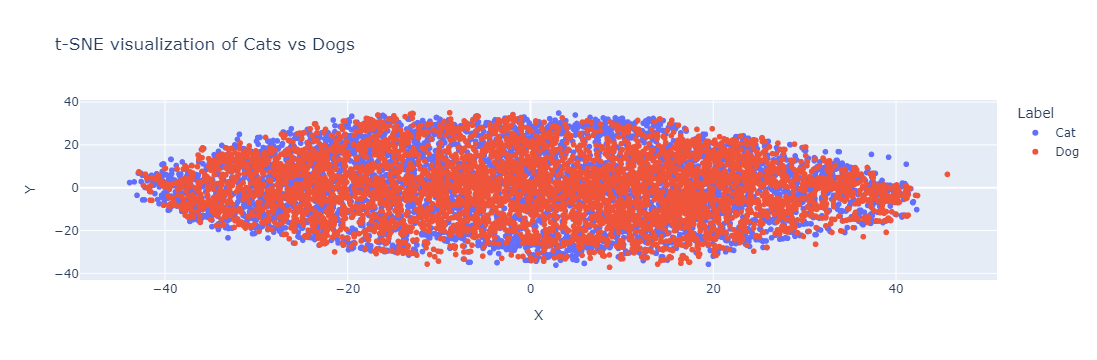

In [22]:
def plot_tsne_data(tsne_data, labels, title):
    df_tsne = pd.DataFrame()
    df_tsne['X'] = tsne_data[:, 0]
    df_tsne['Y'] = tsne_data[:, 1]
    df_tsne['Label'] = labels
    df_tsne['Label'] = df_tsne['Label'].map({0: 'Cat', 1: 'Dog'})
    
    fig = px.scatter(df_tsne, x='X', y='Y', color='Label', title=title)
    fig.show()

plot_tsne_data(images_tsne, labels, 't-SNE visualization of Cats vs Dogs')

In [23]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [24]:
y_val_pred = svm.predict(X_val)
y_val_pred

array([0, 0, 1, ..., 1, 0, 1])

In [25]:
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

In [26]:
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.5290


In [27]:
print('Validation Classification Report:')
print(val_class_report)

Validation Classification Report:
              precision    recall  f1-score   support

         Cat       0.51      0.54      0.53       962
         Dog       0.55      0.52      0.53      1038

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.53      0.53      0.53      2000



Validation Confusion Matrix:
[[523 439]
 [503 535]]


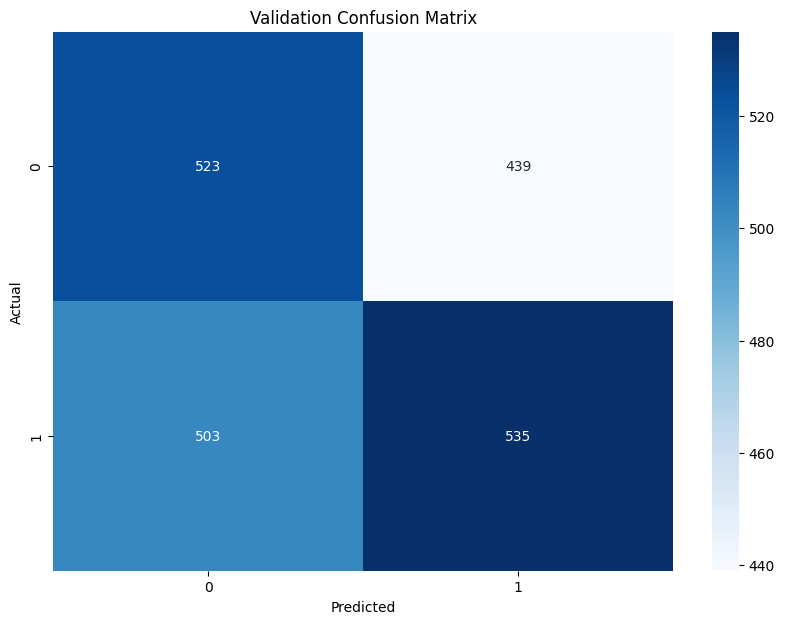

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
print('Validation Confusion Matrix:')
print(val_conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()

In [30]:
import pickle
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [31]:
test_images, test_labels = load_images(test_dir)  
test_images = test_images / 255.0

In [32]:
n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
test_images_flat = test_images.reshape(n_test_samples, -1)
test_images_flat_scaled = scaler.transform(test_images_flat)

In [33]:
test_images_flat_scaled = scaler.transform(test_images_flat)

In [34]:
# Determine a new perplexity value for the test data
test_perplexity = min(30, n_test_samples - 1)

# Create a new t-SNE instance for the test data
test_tsne = TSNE(n_components=2, perplexity=test_perplexity, random_state=42)
test_images_tsne = test_tsne.fit_transform(test_images_flat_scaled)

In [35]:
y_test_pred = svm.predict(test_images_flat_scaled)
y_test_pred

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1])

In [36]:
df_test_tsne = pd.DataFrame()
df_test_tsne['X'] = test_images_tsne[:, 0]
df_test_tsne['Y'] = test_images_tsne[:, 1]
df_test_tsne['Predicted Label'] = y_test_pred
df_test_tsne['Predicted Label'] = df_test_tsne['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

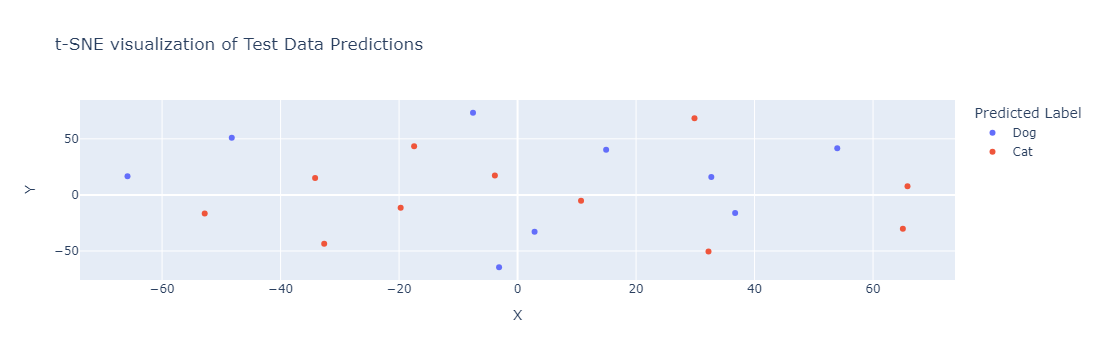

In [37]:
fig = px.scatter(df_test_tsne, x='X', y='Y', color='Predicted Label', title='t-SNE visualization of Test Data Predictions')
fig.show()

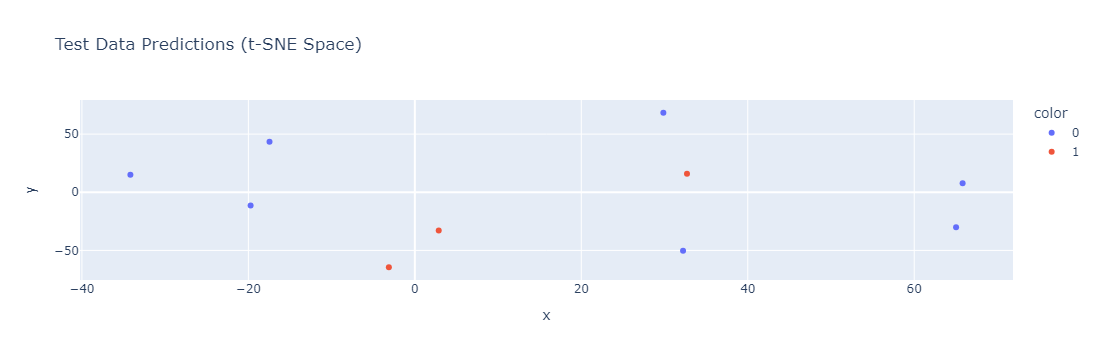

In [38]:
def plot_test_samples(images, tsne_data, predictions, sample_count=10):
    sample_indices = np.random.choice(range(len(images)), sample_count, replace=False)
    sample_images = images[sample_indices]
    tsne_samples = tsne_data[sample_indices]
    pred_samples = predictions[sample_indices]

    fig = px.scatter(tsne_samples, x=tsne_samples[:, 0], y=tsne_samples[:, 1], color=pred_samples.astype(str),
                     title="Test Data Predictions (t-SNE Space)")
    fig.show()

plot_test_samples(test_images, test_images_tsne, y_test_pred)

In [40]:
test_predictions = pd.DataFrame({'Id': np.arange(1, n_test_samples + 1), 'Label': y_test_pred})
test_predictions['Label'] = test_predictions['Label'].map({0: 'Cat', 1: 'Dog'})
test_predictions.to_csv('test_predictions.csv', index=False)

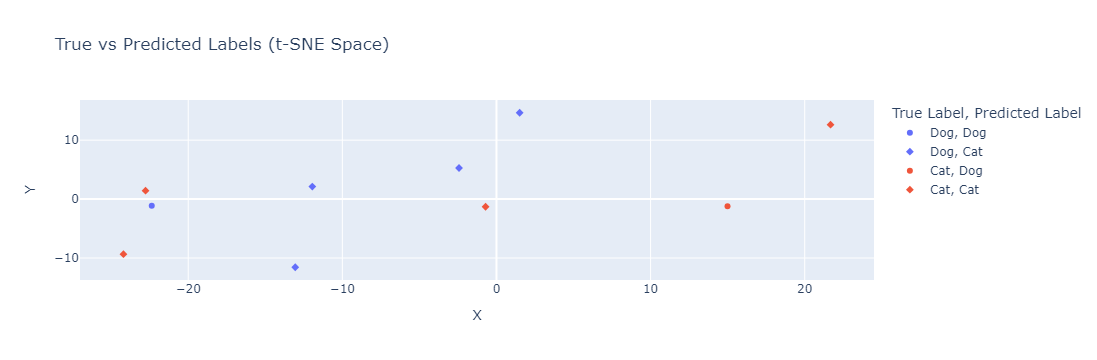

In [41]:
def plot_samples(tsne_data, y_true, y_pred, sample_count=10):
    sample_indices = np.random.choice(range(len(tsne_data)), sample_count, replace=False)
    tsne_samples = tsne_data[sample_indices]
    y_true_samples = y_true[sample_indices]
    y_pred_samples = y_pred[sample_indices]

    df_tsne_samples = pd.DataFrame()
    df_tsne_samples['X'] = tsne_samples[:, 0]
    df_tsne_samples['Y'] = tsne_samples[:, 1]
    df_tsne_samples['True Label'] = y_true_samples
    df_tsne_samples['Predicted Label'] = y_pred_samples
    df_tsne_samples['True Label'] = df_tsne_samples['True Label'].map({0: 'Cat', 1: 'Dog'})
    df_tsne_samples['Predicted Label'] = df_tsne_samples['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

    fig = px.scatter(df_tsne_samples, x='X', y='Y', color='True Label', symbol='Predicted Label', title="True vs Predicted Labels (t-SNE Space)")
    fig.show()

# Apply t-SNE to the validation data
val_tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
val_images_tsne = val_tsne.fit_transform(X_val)

# Plot true vs predicted labels for the validation set
plot_samples(val_images_tsne, y_val, y_val_pred)